# Task 6 -Building a Convolutional neural network

Azucena Ascencio-Cabral, Geoffrey Payne

Features:
- Batch Normalisation
- Dropout
- Adam and SGD otimizers
- Learning rate scheduler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing libraries

In [ ]:
import os,sys
import numpy as np
import torch
import torchvision
from torchvision import transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import torch.optim as optim 
import pickle
import time
import copy
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image


## Training on CUDA or CPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Opening the file

In [ ]:
with open(("/content/drive/My Drive/ck_final.pickle"), "rb") as fh:
    data = pickle.load(fh)
print(data.keys())

dict_keys(['training_data', 'validation_data', 'test_data', 'img_dim'])


In [ ]:
print(data['img_dim'])

{'width': 100, 'height': 100}


## Data Visualisation

(4117, 10000)


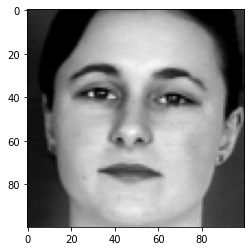

In [ ]:
plt.imshow(data['training_data'][0][200].reshape((100, 100)), cmap="gray")
print(data['training_data'][0].shape)

### Review of the dataset and concatenation
The daset was obtained  from a picklefile. Therefore I will concatenate the splits and proceed with random permutatation to ensure the splits have a even distribution of difficult and easy emotions.

In [ ]:
X_train = data['training_data'][0]
y_train =data['training_data'][1]
X_val = data['validation_data'][0]
y_val =data['validation_data'][1]
X_test= data['test_data'][0]
y_test = data['test_data'][1]


In [ ]:
X= np.append(X_train, X_val, axis = 0)
X= np.append(X, X_test, axis = 0)
y = np.append(y_train, y_val, axis = 0)
y= np.append(y, y_test, axis = 0)


In [ ]:
# Verification of the number of images and labels

print("Labels",len(y))
print("Images",len(X))

Labels 5876
Images 5876


In [ ]:
# Verifiction of the number of emotions
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int8)

In [ ]:
# Creating dictionary for the emotions tracking
emotions = ["neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"]

label ={}
for n, emotion in enumerate (emotions):
    label[n] = emotion
print(label)

{0: 'neutral', 1: 'anger', 2: 'contempt', 3: 'disgust', 4: 'fear', 5: 'happy', 6: 'sadness', 7: 'surprise'}


### Customised dataset class

Here a customised dataset class for thr Cohn-Kanade dataset will be created.

In [ ]:
class CKDataset(Dataset):

    def __init__(self, images, labels, transforms=None):
        self.images = X
        self.labels = y
        self.transforms = transforms

        assert len(images) == len(labels), 'Length of data and label should be same'
        self.length = len(images)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        img = self.images[idx]
        target = int(self.labels[idx])
        img = np.reshape(img, [100, 100,1]) # Reshape for convolutional

        target = int(self.labels[idx])
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

In [ ]:
# pool of square window of size=3, stride=2
m = nn.MaxPool2d(3, stride=2)
# pool of non-square window
m = nn.MaxPool2d((3, 2), stride=(2, 1))
input = torch.randn(20, 16, 50, 32)
output = m(input)
output.shape

torch.Size([20, 16, 24, 31])



###  Build a neural network class
A customised  a convolutional neural network class with droput and batch normalisation options will be built. Dilation and padding will be zero.





#### Output Formula for Convolution
- $ Wout = \frac {Win + 2P[1] - D[1]  x  (K[1] -1 ) -1} {S[1] } + 1$
    - $Wout$: output heigh/length
    - $Win$: input height/length
    - $D$: dilation height/length
    - $K$: filter size (kernel size) = 5
    - $P$: zero padding
     - $ P = \frac{K - 1}{2} $ if padding non-zero
    - $S$: stride
    - $S$: **stride = 1**

    
#### Output Formula for Pooling
- $ O = \frac {W}{K}$
    - W: input height/width
    - K: **filter size = 2**

Here the input width and heigth are (100,100) pixels



-  conv1 = (100 + 2x(0)-1 x (5-1) -1)/1 + 1 = 96 for the first Conv1 
- maxpool1 =  96/2 =  48
- conv2 = (48 -5+ 2(0))/1-1 = 44
- maxpoo12 =44/2 = 22
- fc1 in = 22X 22 X 50 = 24200  # 50 is an arbitary output chanels from conv2 -input for fc1
- fc2 in = 200 # arbitraty number of out channels from fc1 (input for fc2)

For the putrpose of this work batch normalization and droput can be undertaken using the same architectute. Probabilities need to be zeroed when batch normalization is "True". A system exit will be triggered and a message displayed to prompt either bacth normalization or droput. If dropout or batch normalisation are not undertaken, regularization is still possible by using L2 regularization (weight decay) with the optimizer.

**Note:** Comment the system exit if running dropout with batch normalisation

In [ ]:
class ANN(nn.Module):
    def __init__(self, batch_norm = False, is_training = True): #p1,p2,
        super(ANN, self).__init__()
      
        self.training = is_training
        self.batch_norm = batch_norm
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, 
                               kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, 
                               kernel_size=5, stride=1)
        if batch_norm:
            self.conv2_bn = nn.BatchNorm2d(50)
            self.fc1_bn = nn.BatchNorm1d(200) # out features
        self.conv2_drop = nn.Dropout2d(p=p1) #p1=0.4
        self.fc1 = nn.Linear(in_features=24200, out_features= 200)  #22*22*50
        self.fc1_drop = nn.Dropout2d(p=p2) #p2=05
        self.fc2 = nn.Linear(in_features=200, out_features= 8) #8 number of classes


        # if self.batch_norm == True and p1 > 0.0 and p2 > 0.0:
        #   sys.exit("If batch is true zero droput probabilities p1 and p2")
        # if self.batch_norm == True and p1 == 0 and p2 != 0.0:
        #   sys.exit("If batch  is true zero droput probabilities p1 and p2")
        # if self.batch_norm == True and p1 != 0 and p2 == 0 :
        #   sys.exit("If batch is true zero droput probabilities p1 and p2")


    def one_hot_encode(self, y):
        encoded = torch.zeros([10], dtype=torch.float64)
        encoded[y[0]] = 1.
        return encoded    

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        # x= self.conv2(x)

        if batch_norm:
            x = self.conv2_bn(self.conv2(x))
            x = F.relu(x)
            x = F.max_pool2d(x, 2, 2)
            x = self.conv2_drop(x)
            x = x.view(-1, 24200)
            x= self.fc1(x)
            x= self.fc1_bn(x)
            x= F.relu(x)
            x = self.fc1_drop(x)

        else:
            x = F.relu(self.conv2(x))
            x = F.max_pool2d(x, 2, 2)
            x = self.conv2_drop(x)
            x = x.view(-1, 24200)
            x = F.relu(self.fc1(x))

            x = self.fc1_drop(x)         
        x = self.fc2(x)
      
        return x



### Creating the dataset

In [ ]:
# Function to prevent warning caused by PILImage- no. writabletensor. - From pytorch forums

class ToNumpy(object):
    def __call__(self, img):
        return np.array(img)

In [ ]:
# Data augmentation to the training data will be undertaken - T.RandomHorizontalFlip

transform_train = T.Compose([T.ToPILImage(), T.RandomHorizontalFlip(0.5), ToNumpy(), T.ToTensor()])
# Only tensor transformations will be done to the test and validation datasets
transform = T.Compose([T.ToTensor()])



In [ ]:
# # dataset and defined transformations
train_dataset = CKDataset(X, y, transforms = transform_train)
test_dataset = CKDataset(X, y, transforms= transform)


In [ ]:
# split the dataset in train, validation and test datasets using torch random permutations
indices = torch.randperm(len(train_dataset)).tolist()
idx= round(len(indices)*0.70)
train_idx = round(len(indices)*0.85)
train_dataset = torch.utils.data.Subset(train_dataset, indices[:idx])
val_dataset =   torch.utils.data.Subset(test_dataset, indices[idx:train_idx])
test_dataset = torch.utils.data.Subset(test_dataset, indices[train_idx:])


### Loss function and optimizer

In [ ]:
# loss funcion- cross entropy-softmax
criterion = nn.CrossEntropyLoss()


In [ ]:
# Defining SGD and Adam optimizers

def optim (model, opt, lr, momentum, w_decay):
    if opt == "Adam":
        opts= torch.optim.Adam(model.parameters(), lr= learning_rate, weight_decay= w_decay)
    if opt =="SGD":
        opts = torch.optim.SGD(model.parameters(), lr= learning_rate, momentum=mom,
                      weight_decay= w_decay)
    return opts


### Building the training and evaluation functions

In [ ]:

def train(model, loader, criterion, optimizer ):
    model.train()
    loss_sum, correct_sum  = 0, 0
    for idx, (inputs, labels) in enumerate(loader):
        # data pixels and labels to available device
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())
        loss_sum += loss.item()*inputs.size(0)
        # propagate the loss backward
        loss.backward()
        # update the gradients
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        correct_sum += torch.sum(preds == labels) 
    #Statistics 
    train_loss = loss_sum/len(loader.dataset)
    train_acc = correct_sum.float()/len(loader.dataset)

    return train_loss, train_acc


def test_val (model, loader, criterion):
    model.eval()
    test_loss_sum, correct_sum  = 0, 0
    with torch.no_grad():
        loss_sum, correct_sum , total = 0, 0, 0
        for idx, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())
            loss_sum +=  loss.item()*inputs.size(0)
            _, preds = torch.max(outputs, 1) 
            correct_sum += torch.sum(preds == labels)   
        #Statistics 
        loss = loss_sum/len(loader.dataset)
        acc = correct_sum.float()/len(loader.dataset)
        
    return loss, acc


## Building the main - running fucntion

In [ ]:
def main(model, criterion, lr_scheduler, num_epochs):
    since = time.time()

    best_acc = 0.0

    train_loss_log= []
    train_corrects_log = []
    val_loss_log= []
    val_corrects_log = []
    test_loss_log= []
    test_corrects_log = []

    for epoch in range(num_epochs):
        epoch_strlen = len(str(num_epochs)) 
        #getting the loss and accurracy from the training, validation and test datasets
        train_loss, train_acc = train(model, train_loader, criterion, optimizer)
        # lr_scheduler.step()
        val_loss, val_acc = test_val(model, val_loader, criterion)
        test_loss, test_acc = test_val(model, test_loader, criterion)
        if test_acc > best_acc:
            best_acc = test_acc
            best_epoch= int(epoch + 1)
        #     best_model = copy.deepcopy(model.state_dict())

        if lr_scheduler== lr_schedulerpl:
            lr_scheduler.step(test_acc)
        else:
          lr_scheduler.step()
  
        sys.stderr.write('\r%0*d/%d | Train / Val/ Test loss.: %.3f / %.3f / %.3f '' | Train/Val/Test Acc.: %.3f%%/ %.3f%%/ %.3f%% ' 
                    % (epoch_strlen, epoch+1,num_epochs, train_loss, val_loss, test_loss, 
                      train_acc*100, val_acc*100, test_acc*100))
        print('| lr.:{:5f}'.format((optimizer.param_groups[0]['lr'])))
        
    
        train_loss_log.append(train_loss)
        train_corrects_log.append(train_acc)
        val_loss_log.append(val_loss)
        val_corrects_log.append(val_acc)
        test_loss_log.append(test_loss)
        test_corrects_log.append(test_acc)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:3f}'.format(best_acc*100))
    print('Best test epoch: {:2d}'.format(best_epoch))


    return train_loss_log, train_corrects_log, val_loss_log, val_corrects_log, test_loss_log, test_corrects_log

## Preparing the model for training and evaluation

### Hyper parameters

Set gamma to 1 if not learning decay applied
Set p1 and p0 to run without droput
set batch_norm to "False" or "True" if using or not bach normlisation

In [ ]:
num_epochs = 60
batch_size = 10 # 110
batch_norm = True
learning_rate = 0.005

mom = 0.7 # No neededed for Adam optimizer
w_decay =0.001
p1, p2 = 0.5, 0.5
opt = "Adam"  # Select "Adam" or "SGD"

############
#Learning params 
###############
# step learning rate adjustment
step_size = 20
gamma = 0.5 
# plateu learning rate adjustment
factor = 0.5 
patience = 2



### Printing the model

In [ ]:
# Printing the neural network model - move the model to the available device
ann_model = ANN(batch_norm = batch_norm, is_training= True ).to(device)
# Move the model to the available device
ann_model.to(device)

print(ann_model)



ANN(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_bn): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=24200, out_features=200, bias=True)
  (fc1_drop): Dropout2d(p=0.5, inplace=False)
  (fc2): Linear(in_features=200, out_features=8, bias=True)
)


### Build the data loaders and optimizer

In [ ]:
# Data Loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size= batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= batch_size, shuffle=False)

In [ ]:
optimizer = optim(ann_model, opt= opt, lr=learning_rate, momentum=mom, w_decay=w_decay)

In [ ]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 0.001
)


### Learning scheduler

In [ ]:
#Defining learning scheduler -step

lr_schedulerst = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size= step_size, 
                                               gamma=gamma)

#Learning scheduler plateu
lr_schedulerpl = ReduceLROnPlateau(optimizer=optimizer, mode='max',factor= factor, 
                                   patience= patience, verbose= True)

## Runing the model

In [ ]:
train_loss_log, train_corrects_log, val_loss_log, val_corrects_log,test_loss_log, test_corrects_log = main(ann_model, criterion, lr_scheduler= lr_schedulerpl, num_epochs=num_epochs)

01/60 | Train / Val/ Test loss.: 1.492 / 0.987 / 0.967  | Train/Val/Test Acc.: 46.317%/ 67.120%/ 66.288% 

| lr.:0.005000


02/60 | Train / Val/ Test loss.: 1.238 / 0.916 / 0.927  | Train/Val/Test Acc.: 55.288%/ 69.955%/ 70.829% 

| lr.:0.005000


03/60 | Train / Val/ Test loss.: 1.161 / 0.923 / 0.930  | Train/Val/Test Acc.: 58.060%/ 71.655%/ 70.375% 

| lr.:0.005000


04/60 | Train / Val/ Test loss.: 1.117 / 0.787 / 0.795  | Train/Val/Test Acc.: 60.102%/ 73.696%/ 72.985% 

| lr.:0.005000


05/60 | Train / Val/ Test loss.: 1.068 / 0.761 / 0.761  | Train/Val/Test Acc.: 61.877%/ 75.397%/ 74.461% 

| lr.:0.005000


06/60 | Train / Val/ Test loss.: 1.045 / 0.791 / 0.803  | Train/Val/Test Acc.: 63.214%/ 75.397%/ 73.893% 

| lr.:0.005000


07/60 | Train / Val/ Test loss.: 1.035 / 0.673 / 0.669  | Train/Val/Test Acc.: 63.676%/ 79.478%/ 78.888% 

| lr.:0.005000


08/60 | Train / Val/ Test loss.: 0.972 / 0.883 / 0.847  | Train/Val/Test Acc.: 65.402%/ 69.274%/ 71.169% 

| lr.:0.005000


09/60 | Train / Val/ Test loss.: 1.001 / 0.750 / 0.731  | Train/Val/Test Acc.: 64.284%/ 77.098%/ 76.617% 

| lr.:0.005000
Epoch    10: reducing learning rate of group 0 to 2.5000e-03.
| lr.:0.002500


11/60 | Train / Val/ Test loss.: 0.825 / 0.539 / 0.547  | Train/Val/Test Acc.: 70.994%/ 82.880%/ 82.860% 

| lr.:0.002500


12/60 | Train / Val/ Test loss.: 0.796 / 0.496 / 0.470  | Train/Val/Test Acc.: 72.356%/ 84.240%/ 85.585% 

| lr.:0.002500


13/60 | Train / Val/ Test loss.: 0.745 / 0.510 / 0.483  | Train/Val/Test Acc.: 74.204%/ 83.333%/ 83.768% 

| lr.:0.002500


14/60 | Train / Val/ Test loss.: 0.762 / 0.462 / 0.452  | Train/Val/Test Acc.: 72.842%/ 85.374%/ 86.039% 

| lr.:0.002500


15/60 | Train / Val/ Test loss.: 0.723 / 0.502 / 0.494  | Train/Val/Test Acc.: 74.277%/ 82.766%/ 83.087% 

| lr.:0.002500


16/60 | Train / Val/ Test loss.: 0.719 / 0.538 / 0.518  | Train/Val/Test Acc.: 74.666%/ 80.385%/ 81.271% 

| lr.:0.002500
Epoch    17: reducing learning rate of group 0 to 1.2500e-03.
| lr.:0.001250


18/60 | Train / Val/ Test loss.: 0.632 / 0.423 / 0.403  | Train/Val/Test Acc.: 78.094%/ 86.735%/ 87.060% 

| lr.:0.001250


19/60 | Train / Val/ Test loss.: 0.581 / 0.405 / 0.406  | Train/Val/Test Acc.: 79.188%/ 86.735%/ 86.152% 

| lr.:0.001250


20/60 | Train / Val/ Test loss.: 0.575 / 0.383 / 0.374  | Train/Val/Test Acc.: 80.112%/ 87.755%/ 86.606% 

| lr.:0.001250


21/60 | Train / Val/ Test loss.: 0.576 / 0.393 / 0.359  | Train/Val/Test Acc.: 80.452%/ 87.188%/ 87.514% 

| lr.:0.001250


22/60 | Train / Val/ Test loss.: 0.577 / 0.401 / 0.379  | Train/Val/Test Acc.: 79.917%/ 85.828%/ 86.379% 

| lr.:0.001250


23/60 | Train / Val/ Test loss.: 0.559 / 0.364 / 0.343  | Train/Val/Test Acc.: 80.185%/ 87.982%/ 88.763% 

| lr.:0.001250


24/60 | Train / Val/ Test loss.: 0.562 / 0.373 / 0.364  | Train/Val/Test Acc.: 81.084%/ 86.395%/ 86.379% 

| lr.:0.001250


25/60 | Train / Val/ Test loss.: 0.573 / 0.344 / 0.340  | Train/Val/Test Acc.: 80.160%/ 87.868%/ 88.422% 

| lr.:0.001250
Epoch    26: reducing learning rate of group 0 to 6.2500e-04.
| lr.:0.000625


27/60 | Train / Val/ Test loss.: 0.468 / 0.335 / 0.308  | Train/Val/Test Acc.: 84.051%/ 87.982%/ 88.536% 

| lr.:0.000625


28/60 | Train / Val/ Test loss.: 0.474 / 0.321 / 0.298  | Train/Val/Test Acc.: 83.175%/ 88.549%/ 88.536% 

| lr.:0.000625


29/60 | Train / Val/ Test loss.: 0.429 / 0.317 / 0.293  | Train/Val/Test Acc.: 84.829%/ 88.549%/ 88.990% 

| lr.:0.000625


30/60 | Train / Val/ Test loss.: 0.436 / 0.305 / 0.287  | Train/Val/Test Acc.: 84.853%/ 88.776%/ 89.444% 

| lr.:0.000625


31/60 | Train / Val/ Test loss.: 0.437 / 0.300 / 0.293  | Train/Val/Test Acc.: 84.634%/ 89.456%/ 89.330% 

| lr.:0.000625


32/60 | Train / Val/ Test loss.: 0.428 / 0.323 / 0.321  | Train/Val/Test Acc.: 84.780%/ 89.002%/ 89.217% 

| lr.:0.000625


33/60 | Train / Val/ Test loss.: 0.406 / 0.292 / 0.288  | Train/Val/Test Acc.: 85.704%/ 88.549%/ 89.784% 

| lr.:0.000625


34/60 | Train / Val/ Test loss.: 0.405 / 0.289 / 0.302  | Train/Val/Test Acc.: 86.214%/ 88.662%/ 88.990% 

| lr.:0.000625


35/60 | Train / Val/ Test loss.: 0.409 / 0.301 / 0.299  | Train/Val/Test Acc.: 85.825%/ 89.569%/ 88.763% 

| lr.:0.000625
Epoch    36: reducing learning rate of group 0 to 3.1250e-04.
| lr.:0.000313


37/60 | Train / Val/ Test loss.: 0.381 / 0.280 / 0.272  | Train/Val/Test Acc.: 87.065%/ 89.909%/ 90.011% 

| lr.:0.000313


38/60 | Train / Val/ Test loss.: 0.345 / 0.290 / 0.283  | Train/Val/Test Acc.: 88.111%/ 88.776%/ 89.557% 

| lr.:0.000313


39/60 | Train / Val/ Test loss.: 0.350 / 0.291 / 0.277  | Train/Val/Test Acc.: 87.795%/ 87.755%/ 90.238% 

| lr.:0.000313


40/60 | Train / Val/ Test loss.: 0.369 / 0.285 / 0.275  | Train/Val/Test Acc.: 86.847%/ 88.889%/ 90.125% 

| lr.:0.000313


41/60 | Train / Val/ Test loss.: 0.357 / 0.292 / 0.289  | Train/Val/Test Acc.: 87.698%/ 89.002%/ 89.444% 

| lr.:0.000313


42/60 | Train / Val/ Test loss.: 0.339 / 0.271 / 0.254  | Train/Val/Test Acc.: 87.892%/ 89.456%/ 90.919% 

| lr.:0.000313


43/60 | Train / Val/ Test loss.: 0.319 / 0.268 / 0.266  | Train/Val/Test Acc.: 88.694%/ 89.342%/ 90.465% 

| lr.:0.000313


44/60 | Train / Val/ Test loss.: 0.330 / 0.274 / 0.284  | Train/Val/Test Acc.: 88.476%/ 89.456%/ 89.784% 

| lr.:0.000313
Epoch    45: reducing learning rate of group 0 to 1.5625e-04.
| lr.:0.000156


46/60 | Train / Val/ Test loss.: 0.298 / 0.257 / 0.261  | Train/Val/Test Acc.: 90.129%/ 90.590%/ 90.125% 

| lr.:0.000156


47/60 | Train / Val/ Test loss.: 0.300 / 0.258 / 0.262  | Train/Val/Test Acc.: 89.618%/ 90.023%/ 90.919% 

| lr.:0.000156
Epoch    48: reducing learning rate of group 0 to 7.8125e-05.
| lr.:0.000078


49/60 | Train / Val/ Test loss.: 0.285 / 0.254 / 0.240  | Train/Val/Test Acc.: 90.032%/ 89.683%/ 90.465% 

| lr.:0.000078


50/60 | Train / Val/ Test loss.: 0.278 / 0.262 / 0.258  | Train/Val/Test Acc.: 90.153%/ 90.136%/ 90.806% 

| lr.:0.000078
Epoch    51: reducing learning rate of group 0 to 3.9063e-05.
| lr.:0.000039


52/60 | Train / Val/ Test loss.: 0.263 / 0.255 / 0.242  | Train/Val/Test Acc.: 90.883%/ 90.136%/ 90.579% 

| lr.:0.000039


53/60 | Train / Val/ Test loss.: 0.260 / 0.251 / 0.239  | Train/Val/Test Acc.: 90.810%/ 90.023%/ 90.465% 

| lr.:0.000039
Epoch    54: reducing learning rate of group 0 to 1.9531e-05.
| lr.:0.000020


55/60 | Train / Val/ Test loss.: 0.262 / 0.244 / 0.238  | Train/Val/Test Acc.: 90.956%/ 90.363%/ 90.465% 

| lr.:0.000020


56/60 | Train / Val/ Test loss.: 0.248 / 0.262 / 0.266  | Train/Val/Test Acc.: 91.515%/ 90.476%/ 90.465% 

| lr.:0.000020
Epoch    57: reducing learning rate of group 0 to 9.7656e-06.
| lr.:0.000010


58/60 | Train / Val/ Test loss.: 0.261 / 0.246 / 0.237  | Train/Val/Test Acc.: 90.688%/ 90.023%/ 90.919% 

| lr.:0.000010


59/60 | Train / Val/ Test loss.: 0.241 / 0.246 / 0.229  | Train/Val/Test Acc.: 91.636%/ 89.683%/ 91.033% 

| lr.:0.000010
| lr.:0.000010
Training complete in 2m 54s
Best test Acc: 91.032921
Best test epoch: 59


60/60 | Train / Val/ Test loss.: 0.241 / 0.246 / 0.235  | Train/Val/Test Acc.: 91.515%/ 90.476%/ 90.919% 

## Statistics visualisation

#### Cost

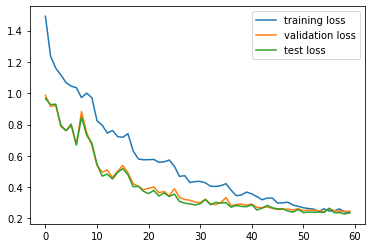

In [ ]:
#Visualising the cost vs epoc

plt.plot(train_loss_log, label='training loss')
plt.plot(val_loss_log, label='validation loss')
plt.plot(test_loss_log, label='test loss')
plt.legend()

#### Accuracy

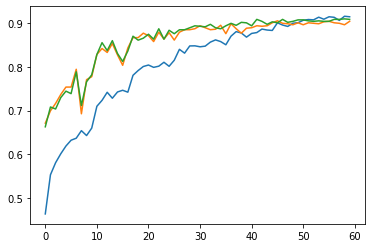

In [ ]:
#Visualising the accuracy vs epoch

plt.plot(train_corrects_log, label='training accuracy')
plt.plot(val_corrects_log, label='val accuracy')
plt.plot(test_corrects_log, label='test accuracy')

### Saving the model

Alternatively the model can be saved. Change the path to your personal path and uncomment the cell.

In [ ]:
path = '/content/drive/My Drive/ck.pth'
torch.save(ann_model.state_dict(), path)

### Visualising the test data

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

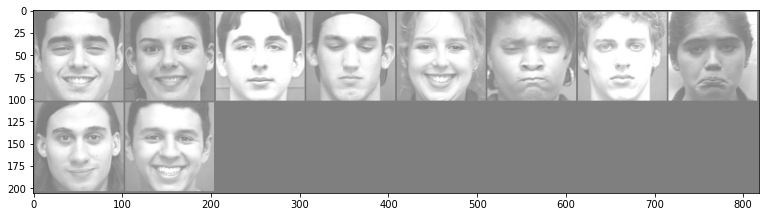

GroundTruth:  happy happy neutral disgust happy anger neutral sadness happy happy


In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
fig = plt.figure(figsize=(13, 7))
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % emotions[labels[j]] for j in range(batch_size)))

### Accessing the saved model -optional

Uncomment this cell if accessing the saved model

In [ ]:
ann_model.state_dict(torch.load(path)) # Change the path to your directory

outputs =ann_model(images.to(device))

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % emotions[predicted[j]]
                              for j in range(batch_size)))

Predicted:  happy happy neutral disgust happy anger disgust sadness happy happy


In [ ]:
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in test_loader:
#         images, labels = data
#         images, labels = images.to(device), labels.to(device)
#         outputs = ann_model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print('Accuracy of the network on the test images: %.2f %%' % (
#     100 * correct / total))

In [ ]:
# # Move the model to the available device
# ann_model.to(device)

### Statistics per label - test dataset

In [ ]:
class_correct = list(0. for i in range(len(emotions)))
class_total = list(0. for i in range(len(emotions)))
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = ann_model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).squeeze()
        if correct.ndim == 0:
            continue
        for i in range(len(test_loader.dataset)):
            if i < len(labels):
                label = labels[i].item()
                class_correct[label] += correct[i].item()
                class_total[label] += 1
for i in range(len(emotions)):
    print('Accuracy of %5s : %.2f %%' % (
        emotions[i], 100 * class_correct[i] / class_total[i]))
    

Accuracy of neutral : 85.59 %
Accuracy of anger : 92.86 %
Accuracy of contempt : 96.15 %
Accuracy of disgust : 92.16 %
Accuracy of  fear : 100.00 %
Accuracy of happy : 97.97 %
Accuracy of sadness : 96.83 %
Accuracy of surprise : 82.78 %
